In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot as plt
import quantum_classical_2Dgamma as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads
from matplotlib import cm
from matplotlib import pyplot as plt, colors
from matplotlib.offsetbox import AnchoredText

[Qibo 0.1.7|INFO|2022-04-13 14:43:43]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-04-13 14:43:43]: qibotf library was not found. `tf.einsum` will be used to apply gates. In order to install Qibo's high performance custom operators for TensorFlow please use `pip install qibotf`. Alternatively, consider installing the qibojit backend.
[Qibo 0.1.7|INFO|2022-04-13 14:43:43]: Using tensorflow backend on /device:CPU:0


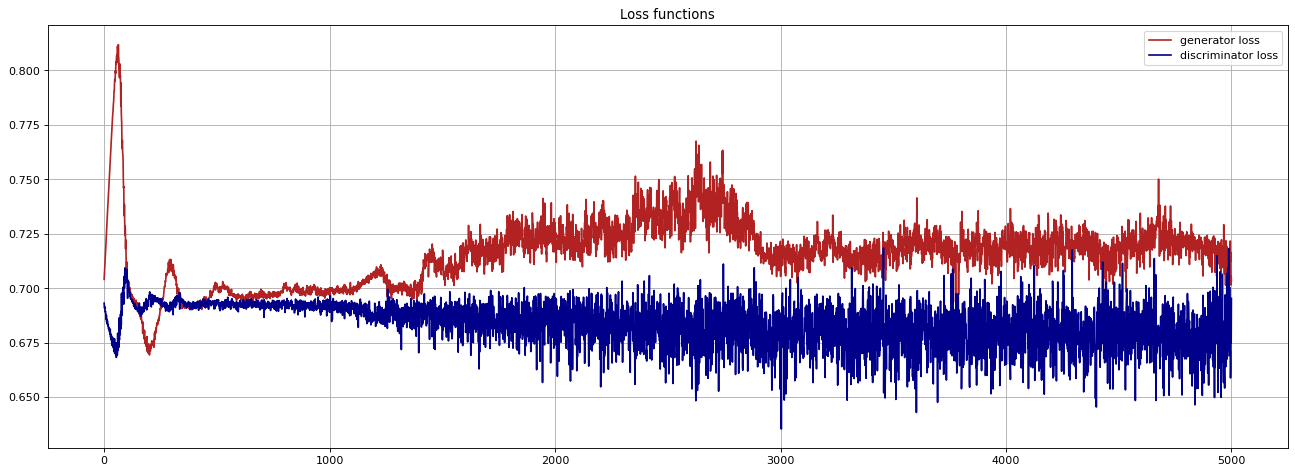

In [2]:
d_loss = np.loadtxt(f"dloss_2Dgaussian_2_3_1_10000_128_0.5_2000", delimiter=' ')
g_loss= np.loadtxt(f"gloss_2Dgaussian_2_3_1_10000_128_0.5_2000", delimiter=' ')
pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss',color="firebrick")
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss',color="darkblue")
pyplot.legend()
pyplot.title("Loss functions")
pyplot.grid()
pyplot.show()
 

In [3]:
def hamiltonian1():
        id = [[1, 0], [0, 1]]
        m0 = hamiltonians.Z(1).matrix
        m0 = np.kron(id, m0)
        ham = hamiltonians.Hamiltonian(2, m0)
        return ham
    
def hamiltonian2():
        id = [[1, 0], [0, 1]]
        m0 = hamiltonians.Z(1).matrix
        m0 = np.kron(m0,id)
        ham = hamiltonians.Hamiltonian(2, m0)
        return ham
    
    

nqubits = 2
latent_dim=3
samples=5000
layers=1
# create hamiltonians
    
hamiltonian1 = hamiltonian1()
hamiltonian2 = hamiltonian2()
   
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
        
    #circuit.add(gates.CRY(0, 1, 0))
            
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))
    
params = np.loadtxt(f"PARAMS_2Dgaussian_2_3_1_10000_128_0.5_2000", delimiter=' ', unpack='true')
#print(params,epochs)
params = tf.Variable(params)

fake_distr, _ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,hamiltonian2)

#x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)


fake_distr=tf.transpose(fake_distr)

training_samples=5000

s = qc.generate_training_real_samples(training_samples)
   
real_distr,_ = qc.generate_real_samples(samples, s, training_samples)
#print(real_distr)
real_distr=tf.transpose(real_distr)



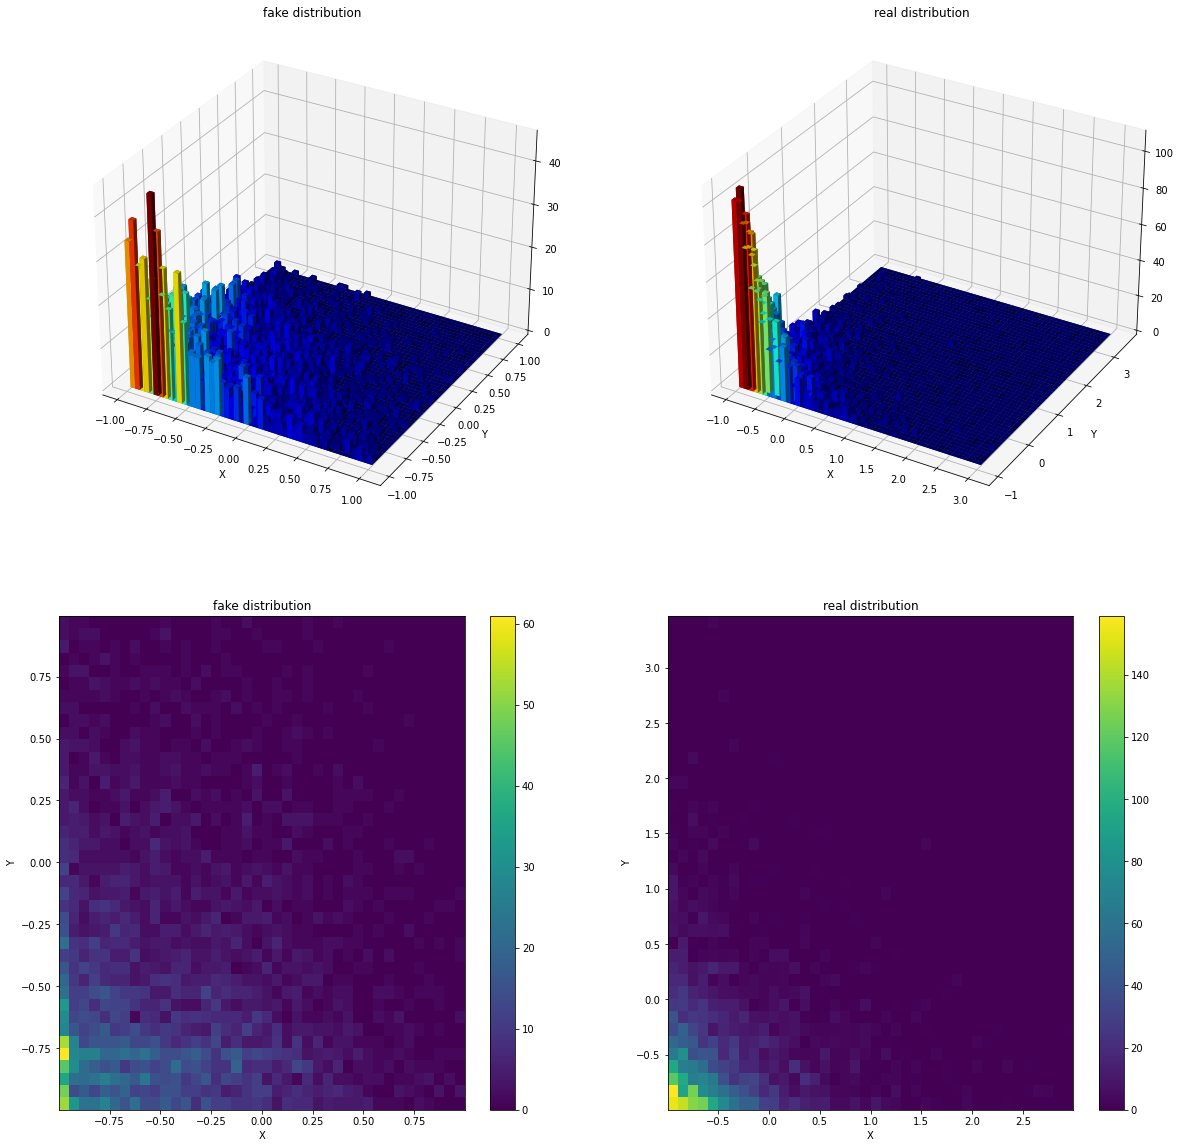

In [4]:
def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems

fig = plt.figure(figsize=(20,20))
def plot_distr(xAmplitudes,yAmplitudes,title,sub=111):
    x = np.array(xAmplitudes)   #turn x,y data into numpy arrays
    y = np.array(yAmplitudes)
    #print(x,y)
              #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(sub, projection='3d')

    #make histogram stuff - set bins - I choose 20x20 because I have a lot of data
    hist, xedges, yedges = np.histogram2d(x, y, bins=(50,50))

    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

    xpos = xpos.flatten()/2.
    ypos = ypos.flatten()/2.
    zpos = np.zeros_like (xpos)

    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = hist.flatten()

    cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    

plot_distr(fake_distr[0],fake_distr[1],"fake distribution",221)
plot_distr(real_distr[0],real_distr[1],"real distribution",222)

#fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(223)

hh = ax.hist2d(fake_distr[0], fake_distr[1] , bins=40)
fig.colorbar(hh[3], ax=ax)
ax.set_title("fake distribution")
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax = fig.add_subplot(224)

hh = ax.hist2d(real_distr[0], real_distr[1] , bins=40)
fig.colorbar(hh[3], ax=ax)
ax.set_title("real distribution")
ax.set_xlabel("X")
ax.set_ylabel("Y")


plt.show()

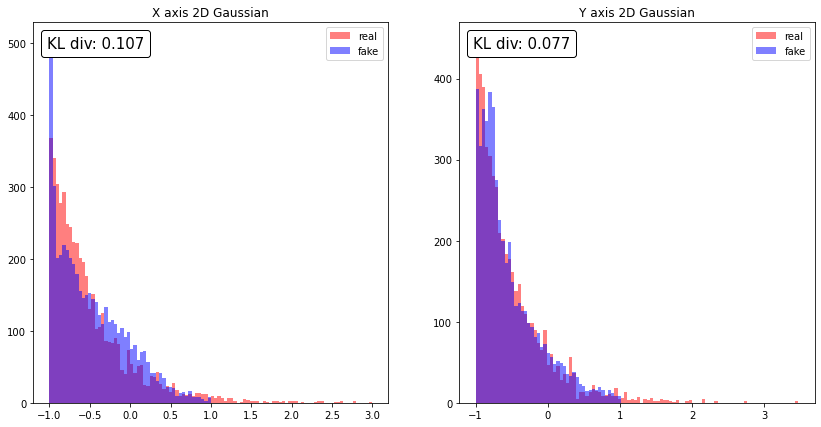

In [5]:
nbins=100

fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(121)

bins_real=pyplot.hist(real_distr[0].numpy(), color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(fake_distr.numpy()[0], bins=bins_real[1],color='blue', label='fake', alpha=0.5)

pyplot.legend()
pyplot.title("X axis 2D Gaussian")
at = AnchoredText(
    f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)


ax = fig.add_subplot(122)

bins_real=pyplot.hist(real_distr[1].numpy(), color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(fake_distr.numpy()[1], bins=bins_real[1],color='blue', label='fake', alpha=0.5)

pyplot.legend()
pyplot.title("Y axis 2D Gaussian")

at = AnchoredText(
    f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)


pyplot.show()